In [1]:
import torch
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import time
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

from srgan import Generator, Discriminator, GeneratorLoss

import sys
sys.path.append('../')
from custom_image_dataset import CustomImageDataset
from image_helper import ImageHelper
from model_runner import ModelRunner

import image_patches

from SRCNN import SRCNN
sys.path.append('../DBPN/')
from DBPN_copied import DBPN


In [2]:
import random
import numpy as np

# Seed for reproducibility
seed = 42  # You can use any seed value

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python's random module
random.seed(seed)

In [3]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [5]:
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"
PATCH_SIZE = 128 # 32 * 4

PATCHES_PER_IMAGE_TRAIN = 30 #####
# PATCHES_PER_IMAGE_TRAIN = 10
PATCHES_PER_IMAGE_VALIDATION = 20 #####
# PATCHES_PER_IMAGE_VALIDATION = 3 
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [6]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [7]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30


 87%|████████▋ | 2552/2920 [01:03<00:09, 38.76it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: Out of bound read in decode_png. Probably, the input image is corrupted


100%|██████████| 2920/2920 [01:12<00:00, 40.53it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:10<00:00, 58.87it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Training set has 87539 instances
Validation set has 12592 instances
CPU times: user 1h 5min 56s, sys: 14.2 s, total: 1h 6min 10s
Wall time: 1min 29s


In [8]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1.25*(2**7))

num_workers = 0

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers)

CPU times: user 1.22 s, sys: 372 ms, total: 1.59 s
Wall time: 1.59 s


In [9]:
netG = Generator(UPSCALE_FACTOR).to(device)
netD = Discriminator().to(device)
generator_criterion = GeneratorLoss().to(device)

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [11]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

d_loss_array = []
g_loss_array = []
d_score_array = []
g_score_array = []


In [12]:
N_EPOCHS = 150 # 150 is good enough for our model. gives decent enough results


In [13]:
model_runner = ModelRunner()

# Lists to store training and validation losses
train_losses = []
val_losses = []
discriminator_losses = []
time_array = []
epoch_array = []
lr_array = []

# Initialize tqdm progress bar for the entire training process
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    epoch_array.append(epoch)
    lr_array.append(optimizerG.param_groups[0]['lr'])

    start_time = time.time()


    running_results = {'batch_sizes': 0, 'd_loss': 0,
                    "g_loss": 0, "d_score": 0, "g_score": 0}

    netG.train()
    netD.train()
    for data, target in train_dataloader:
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        # Move real images and noise vectors to the device
        real_img = Variable(target)
        real_img = real_img.to(device)
        z = Variable(data)
        z = z.to(device)

        ## Update Discriminator ##
        # Generate fake images using the generator
        fake_img = netG(z)
        # Zero out the gradients of the discriminator
        netD.zero_grad()

        # Compute the discriminator scores for real and fake images
        real_out = netD(real_img).mean()        
        fake_out = netD(fake_img).mean()

        # Calculate the discriminator loss
        d_loss = 1 - real_out + fake_out

        # Backpropagate the discriminator loss and update its parameters
        d_loss.backward(retain_graph = True)
        optimizerD.step()

        ## Now update Generator ##
        # Generate fake images again using the updated generator
        fake_img = netG(z)
        # Compute the discriminator score for the generated fake images
        fake_out = netD(fake_img).mean()

        # Zero out the gradients of the generator
        netG.zero_grad()

        # Calculate the generator loss using a predefined criterion
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        
        # Backpropagate the generator loss and update its parameters
        g_loss.backward()
        optimizerG.step()


        # Update the running results with batch-wise metrics
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size # TODO: check if this is correct (fake_out.item() * batch_size maybe?)


        ##### my code #####
        g_loss_array.append(g_loss.item())
        d_loss_array.append(d_loss.item())
        d_score_array.append(real_out.item())
        g_score_array.append(fake_out.item())
        ###################

    # Validation loop
    netG.eval()
    netD.eval()
    val_loss = 0

    # Iterate through each batch in the validation dataloader
    with torch.no_grad():
        for val_data, val_target in validation_dataloader:
            val_batch_size = val_data.size(0)
            real_img_val = Variable(val_target).to(device)
            z_val = Variable(val_data).to(device)

            fake_img_val = netG(z_val)
            fake_out_val = netD(fake_img_val).mean()

            # Calculate validation loss
            val_loss += generator_criterion(fake_out_val, fake_img_val, real_img_val).item()
        
        # Calculate average validation loss
        # avg_val_loss = val_loss # old and I think wrong
        avg_val_loss = val_loss / len(validation_dataloader) # TODO: new and I think correct
        val_losses.append(avg_val_loss)

    end_time = time.time() - start_time
    time_array.append(end_time)

    # Update the tqdm progress bar to show relevant information
    tqdm.write(
        "[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f Val Loss: %.4f Time: %.4f"
        % (
            epoch + 1, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes'],
            avg_val_loss,
            end_time
        ))
    
    # Store training loss for plotting
    train_losses.append(running_results['g_loss'] / running_results['batch_sizes'])

    discriminator_losses.append(running_results['d_loss'] / running_results['batch_sizes'])




Epochs:   0%|          | 0/150 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epochs:   1%|          | 1/150 [06:17<15:36:18, 377.04s/it]

[1/150] Loss_D: 0.0705 Loss_G: 0.0098 D(x): 0.9643 D(G(z)): 0.0288 Val Loss: 0.0073 Time: 377.0333


Epochs:   1%|▏         | 2/150 [12:34<15:30:16, 377.14s/it]

[2/150] Loss_D: 0.0002 Loss_G: 0.0075 D(x): 0.9999 D(G(z)): 0.0002 Val Loss: 0.0069 Time: 377.2069


Epochs:   2%|▏         | 3/150 [18:51<15:23:49, 377.07s/it]

[3/150] Loss_D: 0.1119 Loss_G: 0.0071 D(x): 0.9625 D(G(z)): 0.0711 Val Loss: 0.0059 Time: 376.9859


Epochs:   3%|▎         | 4/150 [25:07<15:17:12, 376.93s/it]

[4/150] Loss_D: 0.0001 Loss_G: 0.0070 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.0062 Time: 376.7248


Epochs:   3%|▎         | 5/150 [31:25<15:11:14, 377.07s/it]

[5/150] Loss_D: 0.0001 Loss_G: 0.0068 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0058 Time: 377.2946


Epochs:   4%|▍         | 6/150 [37:42<15:05:01, 377.10s/it]

[6/150] Loss_D: 0.0000 Loss_G: 0.0066 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0057 Time: 377.1526


Epochs:   5%|▍         | 7/150 [43:59<14:58:50, 377.14s/it]

[7/150] Loss_D: 0.0000 Loss_G: 0.0066 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0053 Time: 377.2213


Epochs:   5%|▌         | 8/150 [50:16<14:52:34, 377.14s/it]

[8/150] Loss_D: 0.0416 Loss_G: 0.0064 D(x): 0.9731 D(G(z)): 0.0128 Val Loss: 0.0054 Time: 377.1573


Epochs:   6%|▌         | 9/150 [56:33<14:46:19, 377.16s/it]

[9/150] Loss_D: 0.0001 Loss_G: 0.0064 D(x): 1.0000 D(G(z)): 0.0001 Val Loss: 0.0052 Time: 377.1847


Epochs:   7%|▋         | 10/150 [1:02:51<14:40:09, 377.21s/it]

[10/150] Loss_D: 0.0000 Loss_G: 0.0063 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0053 Time: 377.3298


Epochs:   7%|▋         | 11/150 [1:09:08<14:33:53, 377.22s/it]

[11/150] Loss_D: 0.0000 Loss_G: 0.0063 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0056 Time: 377.2240


Epochs:   8%|▊         | 12/150 [1:15:25<14:27:43, 377.27s/it]

[12/150] Loss_D: 0.0000 Loss_G: 0.0062 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0051 Time: 377.3982


Epochs:   9%|▊         | 13/150 [1:21:43<14:21:35, 377.34s/it]

[13/150] Loss_D: 0.0000 Loss_G: 0.0062 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0051 Time: 377.4831


Epochs:   9%|▉         | 14/150 [1:28:00<14:15:19, 377.35s/it]

[14/150] Loss_D: 0.0000 Loss_G: 0.0061 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0052 Time: 377.3720


Epochs:  10%|█         | 15/150 [1:34:18<14:08:58, 377.32s/it]

[15/150] Loss_D: 0.0000 Loss_G: 0.0062 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0050 Time: 377.2660


Epochs:  11%|█         | 16/150 [1:40:35<14:02:38, 377.30s/it]

[16/150] Loss_D: 0.0000 Loss_G: 0.0061 D(x): 1.0000 D(G(z)): 0.0002 Val Loss: 0.0053 Time: 377.2365


Epochs:  11%|█▏        | 17/150 [1:46:52<13:56:20, 377.30s/it]

[17/150] Loss_D: 0.0826 Loss_G: 0.0060 D(x): 0.9703 D(G(z)): 0.0483 Val Loss: 0.0053 Time: 377.3026


Epochs:  12%|█▏        | 18/150 [1:53:09<13:49:58, 377.26s/it]

[18/150] Loss_D: 0.0000 Loss_G: 0.0061 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0051 Time: 377.1716


Epochs:  13%|█▎        | 19/150 [1:59:27<13:43:42, 377.27s/it]

[19/150] Loss_D: 0.0124 Loss_G: 0.0060 D(x): 0.9926 D(G(z)): 0.0042 Val Loss: 0.0054 Time: 377.2989


Epochs:  13%|█▎        | 20/150 [2:05:44<13:37:27, 377.29s/it]

[20/150] Loss_D: 0.0000 Loss_G: 0.0060 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0053 Time: 377.3084


Epochs:  14%|█▍        | 21/150 [2:12:01<13:31:02, 377.23s/it]

[21/150] Loss_D: 0.0003 Loss_G: 0.0060 D(x): 0.9998 D(G(z)): 0.0000 Val Loss: 0.0055 Time: 377.0853


Epochs:  15%|█▍        | 22/150 [2:18:18<13:24:35, 377.15s/it]

[22/150] Loss_D: 0.0125 Loss_G: 0.0060 D(x): 0.9925 D(G(z)): 0.0040 Val Loss: 0.0053 Time: 376.9754


Epochs:  15%|█▌        | 23/150 [2:24:35<13:18:12, 377.11s/it]

[23/150] Loss_D: 0.0000 Loss_G: 0.0060 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0051 Time: 376.9987


Epochs:  16%|█▌        | 24/150 [2:30:52<13:11:51, 377.08s/it]

[24/150] Loss_D: 0.0154 Loss_G: 0.0059 D(x): 0.9877 D(G(z)): 0.0027 Val Loss: 0.0055 Time: 377.0057


Epochs:  17%|█▋        | 25/150 [2:37:09<13:05:22, 376.98s/it]

[25/150] Loss_D: 0.0035 Loss_G: 0.0059 D(x): 0.9978 D(G(z)): 0.0006 Val Loss: 0.0048 Time: 376.7486


Epochs:  17%|█▋        | 26/150 [2:43:26<12:58:57, 376.92s/it]

[26/150] Loss_D: 0.0000 Loss_G: 0.0059 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0049 Time: 376.7708


Epochs:  18%|█▊        | 27/150 [2:49:42<12:52:13, 376.69s/it]

[27/150] Loss_D: 0.0000 Loss_G: 0.0059 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0049 Time: 376.1705


Epochs:  19%|█▊        | 28/150 [2:55:58<12:45:45, 376.60s/it]

[28/150] Loss_D: 0.0000 Loss_G: 0.0059 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0052 Time: 376.3882


Epochs:  19%|█▉        | 29/150 [3:02:14<12:39:21, 376.54s/it]

[29/150] Loss_D: 0.0000 Loss_G: 0.0059 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0049 Time: 376.3948


Epochs:  20%|██        | 30/150 [3:08:31<12:33:19, 376.66s/it]

[30/150] Loss_D: 0.0033 Loss_G: 0.0058 D(x): 0.9991 D(G(z)): 0.0021 Val Loss: 0.0052 Time: 376.9478


Epochs:  21%|██        | 31/150 [3:14:48<12:27:15, 376.77s/it]

[31/150] Loss_D: 0.0001 Loss_G: 0.0058 D(x): 0.9999 D(G(z)): 0.0000 Val Loss: 0.0049 Time: 377.0181


Epochs:  21%|██▏       | 32/150 [3:21:05<12:21:07, 376.85s/it]

[32/150] Loss_D: 0.0000 Loss_G: 0.0058 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0052 Time: 377.0172


Epochs:  22%|██▏       | 33/150 [3:27:22<12:14:47, 376.81s/it]

[33/150] Loss_D: 0.0000 Loss_G: 0.0058 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0049 Time: 376.7371


Epochs:  23%|██▎       | 34/150 [3:33:39<12:08:29, 376.81s/it]

[34/150] Loss_D: 0.0000 Loss_G: 0.0058 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0048 Time: 376.7901


Epochs:  23%|██▎       | 35/150 [3:39:56<12:02:10, 376.79s/it]

[35/150] Loss_D: 0.0002 Loss_G: 0.0058 D(x): 0.9998 D(G(z)): 0.0000 Val Loss: 0.0051 Time: 376.7298


Epochs:  24%|██▍       | 36/150 [3:46:13<11:55:57, 376.82s/it]

[36/150] Loss_D: 0.0119 Loss_G: 0.0058 D(x): 0.9908 D(G(z)): 0.0013 Val Loss: 0.0050 Time: 376.9136


Epochs:  25%|██▍       | 37/150 [3:52:29<11:49:27, 376.70s/it]

[37/150] Loss_D: 0.0063 Loss_G: 0.0058 D(x): 0.9952 D(G(z)): 0.0006 Val Loss: 0.0048 Time: 376.4073


Epochs:  25%|██▌       | 38/150 [3:58:46<11:43:15, 376.74s/it]

[38/150] Loss_D: 0.0001 Loss_G: 0.0057 D(x): 1.0000 D(G(z)): 0.0001 Val Loss: 0.0046 Time: 376.8399


Epochs:  26%|██▌       | 39/150 [4:05:02<11:36:49, 376.67s/it]

[39/150] Loss_D: 0.0000 Loss_G: 0.0057 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0047 Time: 376.4807


Epochs:  27%|██▋       | 40/150 [4:11:19<11:30:23, 376.58s/it]

[40/150] Loss_D: 0.0000 Loss_G: 0.0057 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0048 Time: 376.3767


Epochs:  27%|██▋       | 41/150 [4:17:35<11:23:48, 376.41s/it]

[41/150] Loss_D: 0.0000 Loss_G: 0.0057 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0047 Time: 375.9987


Epochs:  28%|██▊       | 42/150 [4:23:48<11:15:38, 375.36s/it]

[42/150] Loss_D: 0.9940 Loss_G: 0.0047 D(x): 0.9997 D(G(z)): 0.9948 Val Loss: 0.0046 Time: 372.9184


Epochs:  29%|██▊       | 43/150 [4:29:59<11:07:25, 374.26s/it]

[43/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 371.6828


Epochs:  29%|██▉       | 44/150 [4:36:09<10:58:55, 372.98s/it]

[44/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0047 Time: 369.9970


Epochs:  30%|███       | 45/150 [4:42:19<10:50:50, 371.91s/it]

[45/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0048 Time: 369.3941


Epochs:  31%|███       | 46/150 [4:48:28<10:43:15, 371.11s/it]

[46/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 369.2438


Epochs:  31%|███▏      | 47/150 [4:54:37<10:36:09, 370.57s/it]

[47/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0047 Time: 369.3247


Epochs:  32%|███▏      | 48/150 [5:00:47<10:29:18, 370.18s/it]

[48/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 369.2647


Epochs:  33%|███▎      | 49/150 [5:06:56<10:22:42, 369.93s/it]

[49/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0047 Time: 369.3360


Epochs:  33%|███▎      | 50/150 [5:13:05<10:16:15, 369.76s/it]

[50/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 369.3518


Epochs:  34%|███▍      | 51/150 [5:19:14<10:09:46, 369.56s/it]

[51/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0047 Time: 369.0908


Epochs:  35%|███▍      | 52/150 [5:25:23<10:03:16, 369.35s/it]

[52/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.8736


Epochs:  35%|███▌      | 53/150 [5:31:32<9:56:46, 369.14s/it] 

[53/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.6492


Epochs:  36%|███▌      | 54/150 [5:37:41<9:50:26, 369.02s/it]

[54/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.7463


Epochs:  37%|███▋      | 55/150 [5:43:49<9:44:04, 368.89s/it]

[55/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.5746


Epochs:  37%|███▋      | 56/150 [5:49:59<9:38:11, 369.06s/it]

[56/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 369.4634


Epochs:  38%|███▊      | 57/150 [5:56:08<9:31:59, 369.02s/it]

[57/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.9222


Epochs:  39%|███▊      | 58/150 [6:02:17<9:25:48, 369.00s/it]

[58/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.9469


Epochs:  39%|███▉      | 59/150 [6:08:26<9:19:39, 369.00s/it]

[59/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 369.0010


Epochs:  40%|████      | 60/150 [6:14:34<9:13:27, 368.97s/it]

[60/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.9010


Epochs:  41%|████      | 61/150 [6:20:43<9:07:19, 368.98s/it]

[61/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0050 Time: 369.0026


Epochs:  41%|████▏     | 62/150 [6:27:00<9:04:34, 371.30s/it]

[62/150] Loss_D: 1.0011 Loss_G: 0.0050 D(x): 0.5728 D(G(z)): 0.5728 Val Loss: 0.0050 Time: 376.7088


Epochs:  42%|████▏     | 63/150 [6:33:17<9:00:57, 373.07s/it]

[63/150] Loss_D: 1.0024 Loss_G: 0.0049 D(x): 0.6551 D(G(z)): 0.6573 Val Loss: 0.0049 Time: 377.1931


Epochs:  43%|████▎     | 64/150 [6:39:35<8:56:31, 374.32s/it]

[64/150] Loss_D: 1.0033 Loss_G: 0.0049 D(x): 0.6750 D(G(z)): 0.6776 Val Loss: 0.0051 Time: 377.2351


Epochs:  43%|████▎     | 65/150 [6:45:52<8:51:28, 375.16s/it]

[65/150] Loss_D: 0.9990 Loss_G: 0.0052 D(x): 0.4365 D(G(z)): 0.4349 Val Loss: 0.0052 Time: 377.1196


Epochs:  44%|████▍     | 66/150 [6:52:09<8:46:05, 375.78s/it]

[66/150] Loss_D: 0.9998 Loss_G: 0.0050 D(x): 0.6142 D(G(z)): 0.6133 Val Loss: 0.0047 Time: 377.2141


Epochs:  45%|████▍     | 67/150 [6:58:26<8:40:20, 376.15s/it]

[67/150] Loss_D: 1.0030 Loss_G: 0.0047 D(x): 0.8420 D(G(z)): 0.8445 Val Loss: 0.0048 Time: 377.0087


Epochs:  45%|████▌     | 68/150 [7:04:43<8:34:28, 376.45s/it]

[68/150] Loss_D: 1.0004 Loss_G: 0.0048 D(x): 0.7426 D(G(z)): 0.7421 Val Loss: 0.0048 Time: 377.1380


Epochs:  46%|████▌     | 69/150 [7:11:00<8:28:24, 376.60s/it]

[69/150] Loss_D: 1.0018 Loss_G: 0.0048 D(x): 0.7561 D(G(z)): 0.7576 Val Loss: 0.0046 Time: 376.9632


Epochs:  47%|████▋     | 70/150 [7:17:10<8:19:35, 374.69s/it]

[70/150] Loss_D: 1.0007 Loss_G: 0.0046 D(x): 0.9847 D(G(z)): 0.9856 Val Loss: 0.0056 Time: 370.2312


Epochs:  47%|████▋     | 71/150 [7:23:19<8:10:49, 372.78s/it]

[71/150] Loss_D: 1.0000 Loss_G: 0.0046 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.3199


Epochs:  48%|████▊     | 72/150 [7:29:27<8:02:49, 371.40s/it]

[72/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1785


Epochs:  49%|████▊     | 73/150 [7:35:35<7:55:21, 370.41s/it]

[73/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.1091


Epochs:  49%|████▉     | 74/150 [7:41:43<7:48:19, 369.73s/it]

[74/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.1244


Epochs:  50%|█████     | 75/150 [7:47:51<7:41:37, 369.30s/it]

[75/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.2976


Epochs:  51%|█████     | 76/150 [7:54:00<7:35:04, 368.98s/it]

[76/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.2412


Epochs:  51%|█████▏    | 77/150 [8:00:08<7:28:37, 368.73s/it]

[77/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.1304


Epochs:  52%|█████▏    | 78/150 [8:06:16<7:22:12, 368.51s/it]

[78/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.9930


Epochs:  53%|█████▎    | 79/150 [8:12:24<7:16:00, 368.45s/it]

[79/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.3191


Epochs:  53%|█████▎    | 80/150 [8:18:32<7:09:44, 368.35s/it]

[80/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1248


Epochs:  54%|█████▍    | 81/150 [8:24:40<7:03:25, 368.19s/it]

[81/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0049 Time: 367.8045


Epochs:  55%|█████▍    | 82/150 [8:30:48<6:57:14, 368.15s/it]

[82/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.0578


Epochs:  55%|█████▌    | 83/150 [8:36:56<6:51:01, 368.08s/it]

[83/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.8985


Epochs:  56%|█████▌    | 84/150 [8:43:04<6:44:57, 368.15s/it]

[84/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.3145


Epochs:  57%|█████▋    | 85/150 [8:49:12<6:38:46, 368.10s/it]

[85/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.9982


Epochs:  57%|█████▋    | 86/150 [8:55:20<6:32:37, 368.08s/it]

[86/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.0219


Epochs:  58%|█████▊    | 87/150 [9:01:28<6:26:27, 368.05s/it]

[87/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.9727


Epochs:  59%|█████▊    | 88/150 [9:07:36<6:20:17, 368.03s/it]

[88/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.9712


Epochs:  59%|█████▉    | 89/150 [9:13:44<6:14:12, 368.07s/it]

[89/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1630


Epochs:  60%|██████    | 90/150 [9:19:52<6:08:02, 368.04s/it]

[90/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.9777


Epochs:  61%|██████    | 91/150 [9:26:01<6:01:56, 368.07s/it]

[91/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1347


Epochs:  61%|██████▏   | 92/150 [9:32:09<5:55:50, 368.10s/it]

[92/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1778


Epochs:  62%|██████▏   | 93/150 [9:38:17<5:49:41, 368.09s/it]

[93/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.0510


Epochs:  63%|██████▎   | 94/150 [9:44:25<5:43:28, 368.01s/it]

[94/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.8295


Epochs:  63%|██████▎   | 95/150 [9:50:33<5:37:20, 368.01s/it]

[95/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.0158


Epochs:  64%|██████▍   | 96/150 [9:56:41<5:31:10, 367.98s/it]

[96/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.8857


Epochs:  65%|██████▍   | 97/150 [10:02:48<5:25:01, 367.96s/it]

[97/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.9068


Epochs:  65%|██████▌   | 98/150 [10:08:56<5:18:53, 367.95s/it]

[98/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.9252


Epochs:  66%|██████▌   | 99/150 [10:15:04<5:12:45, 367.95s/it]

[99/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 367.9563


Epochs:  67%|██████▋   | 100/150 [10:21:13<5:06:42, 368.05s/it]

[100/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.2707


Epochs:  67%|██████▋   | 101/150 [10:27:21<5:00:36, 368.08s/it]

[101/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1689


Epochs:  68%|██████▊   | 102/150 [10:33:28<4:54:23, 367.98s/it]

[102/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.7326


Epochs:  69%|██████▊   | 103/150 [10:39:37<4:48:19, 368.08s/it]

[103/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.3114


Epochs:  69%|██████▉   | 104/150 [10:45:45<4:42:07, 367.99s/it]

[104/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.7694


Epochs:  70%|███████   | 105/150 [10:51:53<4:35:58, 367.97s/it]

[105/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 367.9410


Epochs:  71%|███████   | 106/150 [10:58:01<4:29:51, 367.99s/it]

[106/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.0148


Epochs:  71%|███████▏  | 107/150 [11:04:09<4:23:47, 368.08s/it]

[107/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.2821


Epochs:  72%|███████▏  | 108/150 [11:10:17<4:17:40, 368.12s/it]

[108/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.2139


Epochs:  73%|███████▎  | 109/150 [11:16:25<4:11:31, 368.08s/it]

[109/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0047 Time: 367.9999


Epochs:  73%|███████▎  | 110/150 [11:22:33<4:05:22, 368.06s/it]

[110/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0054 Time: 368.0015


Epochs:  74%|███████▍  | 111/150 [11:28:41<3:59:11, 368.00s/it]

[111/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.8510


Epochs:  75%|███████▍  | 112/150 [11:34:49<3:53:05, 368.03s/it]

[112/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.0990


Epochs:  75%|███████▌  | 113/150 [11:40:57<3:46:55, 367.98s/it]

[113/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.8614


Epochs:  76%|███████▌  | 114/150 [11:47:05<3:40:48, 368.02s/it]

[114/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.0990


Epochs:  77%|███████▋  | 115/150 [11:53:13<3:34:39, 367.99s/it]

[115/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.9355


Epochs:  77%|███████▋  | 116/150 [11:59:21<3:28:31, 367.97s/it]

[116/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.9207


Epochs:  78%|███████▊  | 117/150 [12:05:29<3:22:24, 368.01s/it]

[117/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1017


Epochs:  79%|███████▊  | 118/150 [12:11:37<3:16:18, 368.09s/it]

[118/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.2619


Epochs:  79%|███████▉  | 119/150 [12:17:45<3:10:08, 368.02s/it]

[119/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.8641


Epochs:  80%|████████  | 120/150 [12:23:53<3:03:59, 367.99s/it]

[120/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.9293


Epochs:  81%|████████  | 121/150 [12:30:01<2:57:50, 367.96s/it]

[121/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.8880


Epochs:  81%|████████▏ | 122/150 [12:36:09<2:51:42, 367.96s/it]

[122/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 367.9405


Epochs:  82%|████████▏ | 123/150 [12:42:17<2:45:36, 368.01s/it]

[123/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.1321


Epochs:  83%|████████▎ | 124/150 [12:48:25<2:39:28, 368.02s/it]

[124/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.0303


Epochs:  83%|████████▎ | 125/150 [12:54:33<2:33:19, 367.97s/it]

[125/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.8505


Epochs:  84%|████████▍ | 126/150 [13:00:41<2:27:12, 368.02s/it]

[126/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1277


Epochs:  85%|████████▍ | 127/150 [13:06:49<2:21:05, 368.04s/it]

[127/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.1038


Epochs:  85%|████████▌ | 128/150 [13:12:57<2:14:58, 368.13s/it]

[128/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.3142


Epochs:  86%|████████▌ | 129/150 [13:19:06<2:08:51, 368.18s/it]

[129/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.3040


Epochs:  87%|████████▋ | 130/150 [13:25:14<2:02:43, 368.16s/it]

[130/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.1214


Epochs:  87%|████████▋ | 131/150 [13:31:22<1:56:37, 368.30s/it]

[131/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.6324


Epochs:  88%|████████▊ | 132/150 [13:37:31<1:50:28, 368.24s/it]

[132/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.0837


Epochs:  89%|████████▊ | 133/150 [13:43:39<1:44:19, 368.21s/it]

[133/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0046 Time: 368.1521


Epochs:  89%|████████▉ | 134/150 [13:49:47<1:38:12, 368.26s/it]

[134/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.3810


Epochs:  90%|█████████ | 135/150 [13:55:55<1:32:03, 368.23s/it]

[135/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.1481


Epochs:  91%|█████████ | 136/150 [14:02:03<1:25:53, 368.14s/it]

[136/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0076 Time: 367.9342


Epochs:  91%|█████████▏| 137/150 [14:08:11<1:19:45, 368.10s/it]

[137/150] Loss_D: 1.0000 Loss_G: 0.0047 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0047 Time: 367.9972


Epochs:  92%|█████████▏| 138/150 [14:14:19<1:13:35, 367.96s/it]

[138/150] Loss_D: 1.0000 Loss_G: 0.0045 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.6374


Epochs:  93%|█████████▎| 139/150 [14:20:27<1:07:27, 367.91s/it]

[139/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.7918


Epochs:  93%|█████████▎| 140/150 [14:26:34<1:01:18, 367.89s/it]

[140/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.8511


Epochs:  94%|█████████▍| 141/150 [14:32:42<55:10, 367.89s/it]  

[141/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.8618


Epochs:  95%|█████████▍| 142/150 [14:38:50<49:02, 367.82s/it]

[142/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.6758


Epochs:  95%|█████████▌| 143/150 [14:44:58<42:55, 367.88s/it]

[143/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.0026


Epochs:  96%|█████████▌| 144/150 [14:51:06<36:47, 367.98s/it]

[144/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0045 Time: 368.2163


Epochs:  97%|█████████▋| 145/150 [14:57:14<30:40, 368.03s/it]

[145/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.1432


Epochs:  97%|█████████▋| 146/150 [15:03:23<24:32, 368.08s/it]

[146/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0053 Time: 368.2058


Epochs:  98%|█████████▊| 147/150 [15:09:30<18:24, 368.02s/it]

[147/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.8815


Epochs:  99%|█████████▊| 148/150 [15:15:39<12:16, 368.03s/it]

[148/150] Loss_D: 1.0000 Loss_G: 0.0044 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.0319


Epochs:  99%|█████████▉| 149/150 [15:21:46<06:07, 367.98s/it]

[149/150] Loss_D: 1.0000 Loss_G: 0.0043 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 367.8553


Epochs: 100%|██████████| 150/150 [15:27:54<00:00, 371.17s/it]

[150/150] Loss_D: 1.0000 Loss_G: 0.0043 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0044 Time: 368.0627


In [14]:
# epoch_array.pop()
# lr_array.pop()
print(len(epoch_array))
print(len(lr_array))
print(len(time_array))
print(len(train_losses))
print(len(val_losses))
print(len(discriminator_losses))

150
150
150
150
150
150


In [15]:
# EU CALCULEI A MEDIA ERRADO, SÓ SOMEI AS LOSSES, FALTOU DIVIDIR PELO len(train_dataloader)
# old_val_losses = val_losses.copy()
# old_val_losses

# new_val_losses = [item / len(validation_dataloader) for item in val_losses]

In [16]:
# df = model_runner.create_model_df(epoch_array, time_array, lr_array, train_losses, new_val_losses,
df = model_runner.create_model_df(epoch_array, time_array, lr_array, train_losses, val_losses,
                            extra_columns={"discriminator_losses": discriminator_losses}        
)
df

,epoch,time,lr,train_loss,validation_loss,discriminator_losses
0,0,377.033309,0.0002,0.009846,0.007328,0.070456
1,1,377.206854,0.0002,0.007456,0.006886,0.000241
2,2,376.985874,0.0002,0.007126,0.005908,0.111865
3,3,376.724793,0.0002,0.006956,0.006191,0.000147
4,4,377.294639,0.0002,0.006774,0.005771,0.000063
...,...,...,...,...,...,...
145,145,368.205811,0.0002,0.004355,0.005274,1.000000
146,146,367.881523,0.0002,0.004381,0.004436,1.000000
147,147,368.031930,0.0002,0.004351,0.004431,1.000000
148,148,367.855331,0.0002,0.004350,0.004424,1.000000


In [ ]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


should_upsample MUST ONLY BE `TRUE` for SRCNN


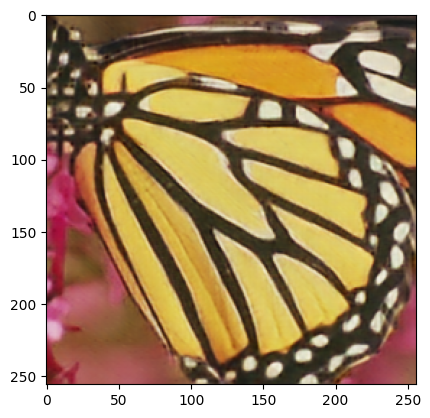

In [17]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True,
    should_upsample=False
)

In [18]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:01, 56.11it/s]
100it [00:01, 93.91it/s]


,PSNR,SSIM
SRGAN,25.624023,0.680848
Bicubic,23.045410,0.632868


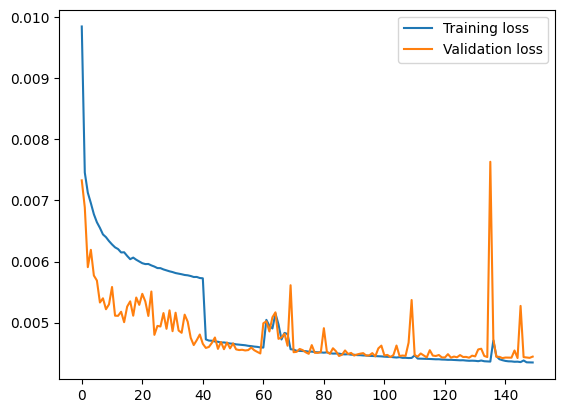

In [19]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(df['train_loss'], label='Training loss')
plt.plot(df['validation_loss'], label='Validation loss')
plt.legend()
plt.show()


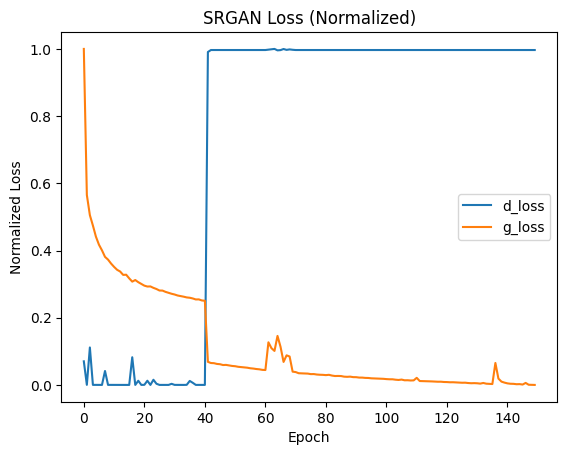

In [20]:
normalized_discriminator_losses = model_runner.normalize_data(discriminator_losses)
normalized_train_losses = model_runner.normalize_data(train_losses)

# Plot normalized data
plt.plot(normalized_discriminator_losses, label='d_loss')
plt.plot(normalized_train_losses, label='g_loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('SRGAN Loss (Normalized)')
plt.legend()
plt.show()


In [21]:
# model_runner.save_model_df("./../results/srgan/dataframes/srgan_netG_with_correct_VGG_follwing_paper_df_150.csv", df_to_save=df)

In [22]:
import pandas as pd
df_new = pd.read_csv("./../results/srgan/dataframes/srgan_netG_with_correct_VGG_follwing_paper_df_150.csv")
df_new

,epoch,time,lr,train_loss,validation_loss,discriminator_losses
0,0,377.033309,0.0002,0.009846,0.007328,0.070456
1,1,377.206854,0.0002,0.007456,0.006886,0.000241
2,2,376.985874,0.0002,0.007126,0.005908,0.111865
3,3,376.724793,0.0002,0.006956,0.006191,0.000147
4,4,377.294639,0.0002,0.006774,0.005771,0.000063
...,...,...,...,...,...,...
145,145,368.205811,0.0002,0.004355,0.005274,1.000000
146,146,367.881523,0.0002,0.004381,0.004436,1.000000
147,147,368.031930,0.0002,0.004351,0.004431,1.000000
148,148,367.855331,0.0002,0.004350,0.004424,1.000000


In [23]:
# model_runner.save_model_weights(netG, '../results/srgan/trained_models/srgan_netG_with_correct_VGG_follwing_paper_150.pth')
# model_runner.save_model_weights(netD, '../results/srgan/trained_models/srgan_netD_with_correct_VGG_follwing_paper_150.pth')

In [24]:
netG_test = Generator(UPSCALE_FACTOR).to('cpu')
netG_test.load_state_dict(torch.load('../results/srgan/trained_models/srgan_netG_with_correct_VGG_follwing_paper_150.pth',  map_location=torch.device('cpu')))


<All keys matched successfully>

should_upsample MUST ONLY BE `TRUE` for SRCNN


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


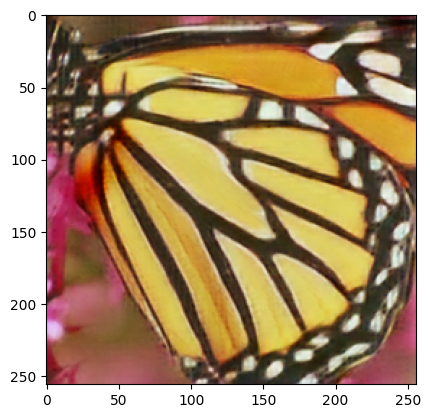

In [25]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG_test.to('cpu'),
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True,
    should_upsample=False,
    device='cpu'
)

In [22]:
model_runner = ModelRunner(device='cpu')
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:12,  7.72it/s]
100it [00:02, 44.86it/s]


,PSNR,SSIM
SRGAN,24.13529,0.664658
Bicubic,23.04541,0.632869


In [32]:
model_runner = ModelRunner(device='cpu')
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:13,  7.18it/s]
100it [00:02, 45.73it/s]


,PSNR,SSIM
SRGAN,22.76432,0.647017
Bicubic,23.04541,0.632869


In [27]:
model_f2_5 = SRCNN(f2=5).to(device)
model_f2_5.load_state_dict(torch.load('../results/srcnn/trained_models/model_f2_5.pth', map_location=torch.device('cpu')))

model_without_noise = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_without_noise.load_state_dict(torch.load('./trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth', map_location=torch.device('cpu')))


FileNotFoundError: [Errno 2] No such file or directory: './trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


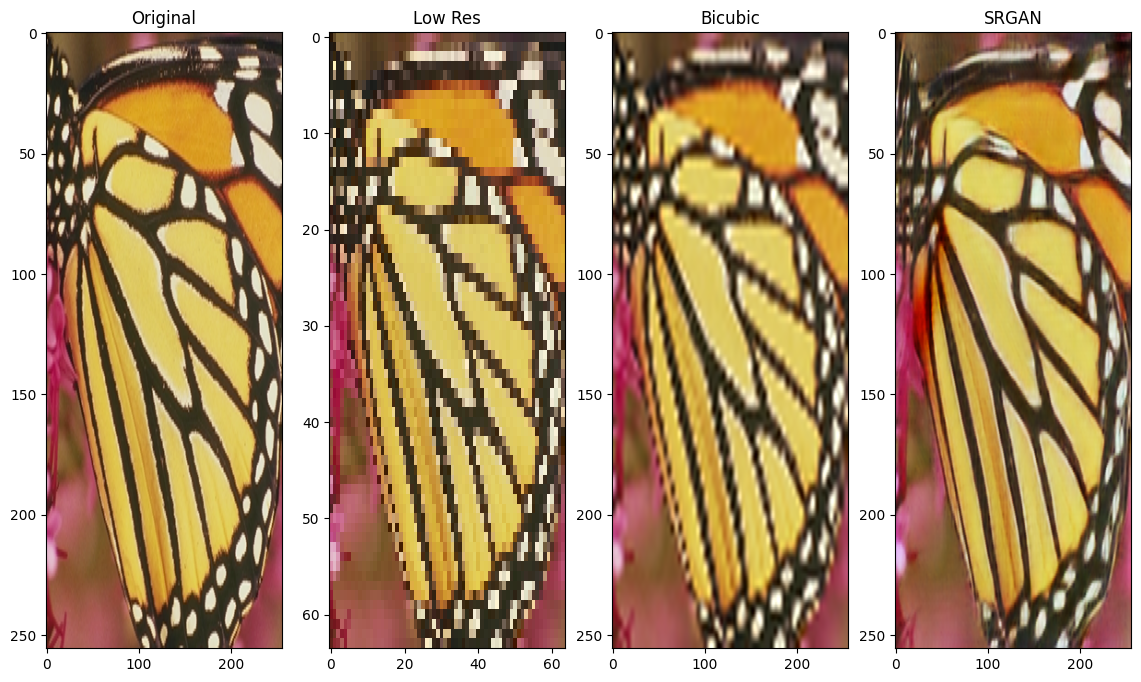

In [27]:
IMAGE_EXAMPLE = f"../datasets/Set5/butterfly.png"

image_helper.show_tensor_as_images_side_by_side(
    [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        # {
        #     "label": "SRCNN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model_f2_5,
        #         IMAGE_EXAMPLE,
        #         4
        #     )
        # },
        {
            "label": "SRGAN",
            "tensor": image_helper.apply_model_to_image(
                netG_test.to('cpu'),
                IMAGE_EXAMPLE,
                downsample_factor=4,
                should_upsample=False,
                unsqueeze=True,
                device='cpu'
            )
        },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=test_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v4 (triangular)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v5 (triangular2)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular2,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v6 (triangular2)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular2,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=more_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=even_more_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN *",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=more_epochs_less_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
    ],
)

In [30]:
model_runner.compare_models(
    [
        {
            "name": "SRCNN",
            "model": model_f2_5,
        },
        {"name": "DBPN without noise", "model": model_without_noise,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

100it [00:04, 24.49it/s]
100it [01:23,  1.19it/s]
100it [00:07, 13.97it/s]
100it [00:01, 70.65it/s]


,PSNR,SSIM
SRCNN,23.475697,0.630280
DBPN without noise,9.236373,0.055450
SRGAN,24.347925,0.667682
Bicubic,23.045410,0.632869
